<a href="https://colab.research.google.com/github/KnzMcn/Attempts-At-Learning-CNN/blob/main/cnn_with_imagedatasetfromdirectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive
import zipfile
import os
from PIL import Image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Rescaling, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, image_dataset_from_directory
from keras.optimizers import RMSprop
#from tensorflow.data import AUTOTUNE

# Import the dataset

In [2]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzip the dataset file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/3rd year/Machine Learning/Learning Evidence/Alzheimers.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
#resize the image for faster processing
main_directory = '/content/Alzheimers/'

for subdir, dirs, files in os.walk(main_directory):
  for file in files:
    filepath = os.path.join(subdir, file)

    if filepath.endswith('.jpg'):
      im = Image.open(filepath)
      imResize = im.resize((80, 80), Image.ANTIALIAS)
      imResize.save(filepath, 'JPEG', quality=90)

In [70]:
# generate the image datasets
train_set = image_dataset_from_directory('/content/Alzheimers/train',
                                         label_mode = 'int',
                                         color_mode = 'grayscale',
                                         batch_size = 256, 
                                         image_size = (80, 80),  
                                         validation_split = 0.2,                                                                    
                                         subset = 'training',
                                         seed = 0)

val_set = image_dataset_from_directory('/content/Alzheimers/train',
                                       label_mode = 'int',
                                       color_mode = 'grayscale',
                                       batch_size = 256,
                                       image_size = (80, 80),
                                       validation_split = 0.2,
                                       subset = 'validation',
                                       seed = 0)

test_set = image_dataset_from_directory('/content/Alzheimers/test',
                                        label_mode = 'int',
                                        color_mode = 'grayscale',
                                        batch_size = 256, 
                                        image_size = (80, 80))

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


In [6]:
# get the class labels
class_labels = train_set.class_names
class_labels

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

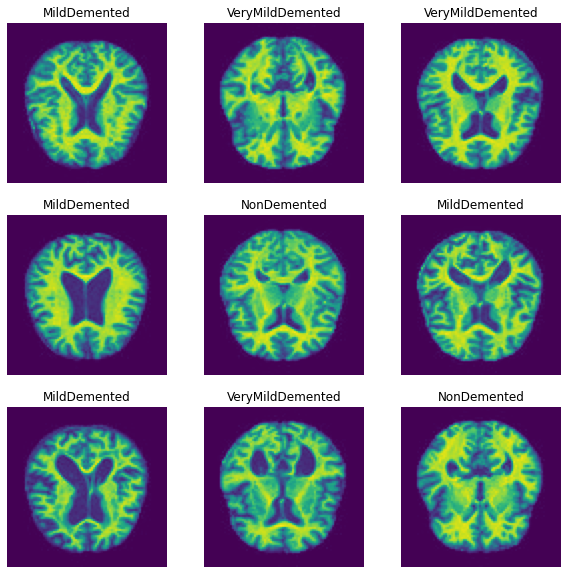

In [7]:
# display the images
plt.figure(figsize = (10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('float32').reshape(80, 80))
    plt.title(class_labels[labels[i]])
    plt.axis('off')

In [62]:
# retrive the batches and labels of the train and test set
for batch, labels in train_set:
  train_labels = labels
  print(batch.shape, labels.shape)
  break

for batch, labels in test_set:
  test_labels = labels
  print(batch.shape, test_labels.shape)
  break

(256, 80, 80, 1) (256,)
(1279, 80, 80, 1) (1279,)


# Preprocessing

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)

In [13]:
# do a one hot encoding of the test labels
test_encoded = to_categorical(test_labels)

# Convolutional Neural Network

In [14]:
# state the number of classes and input shape
num_classes = 4
input_img = (80, 80, 1)

In [15]:
# build the network
cnn = Sequential([Input(shape = input_img), 
                  Rescaling(1./255),
                  
                  #Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'),
                  #MaxPooling2D(2),
                  #Dropout(0.5),              

                  Conv2D(128, kernel_size = 3, activation = 'relu', padding = 'same'),
                  MaxPooling2D(2),
                  Dropout(0.75),

                  Flatten(),
                  Dense(128, activation = 'relu'),
                  Dropout(0.50),
                  Dense(num_classes, activation = 'softmax')])

In [16]:
# compile the network
cnn.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy'])
cnn.build(input_img)

In [17]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 80, 80, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 40, 128)       0         
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                        

# Train the model using the Generator

In [18]:
cnn_history = cnn.fit(train_set,
                      #steps_per_epoch = len(train_set)/256,
                      epochs = 30, 
                      verbose = 1,
                      validation_data = val_set)

Epoch 1/30
17/17 [==============================] - 79s 4s/step - loss: 2.9161 - accuracy: 0.3883 - val_loss: 1.1239 - val_accuracy: 0.5020
Epoch 2/30
17/17 [==============================] - 72s 4s/step - loss: 1.0942 - accuracy: 0.5016 - val_loss: 1.0356 - val_accuracy: 0.5020
Epoch 3/30
17/17 [==============================] - 67s 4s/step - loss: 1.0377 - accuracy: 0.5021 - val_loss: 1.0023 - val_accuracy: 0.5020
Epoch 4/30
17/17 [==============================] - 73s 4s/step - loss: 1.0091 - accuracy: 0.5170 - val_loss: 0.9769 - val_accuracy: 0.5107
Epoch 5/30
17/17 [==============================] - 72s 4s/step - loss: 0.9804 - accuracy: 0.5345 - val_loss: 0.9441 - val_accuracy: 0.5322
Epoch 6/30
17/17 [==============================] - 67s 4s/step - loss: 0.9316 - accuracy: 0.5636 - val_loss: 0.9044 - val_accuracy: 0.5547
Epoch 7/30
17/17 [==============================] - 70s 4s/step - loss: 0.8911 - accuracy: 0.5917 - val_loss: 0.8832 - val_accuracy: 0.5625
Epoch 8/30
17/17 [==

In [19]:
# save the model
cnn.save('cnn.h5')

# Visualization

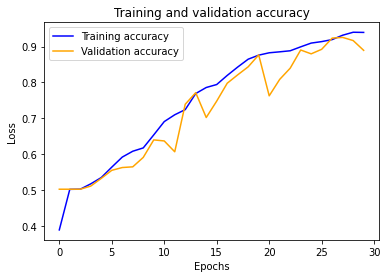

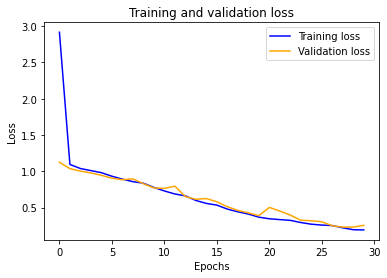

In [20]:
#visualization of the model evaluation
#plot image will change with more epochs
accuracy = cnn_history.history['accuracy']
val_accuracy = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epochs = range(len(accuracy))

#Visualize the accuracy
plt.plot(epochs, accuracy, 'b', c = 'blue', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', c = 'orange', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

#Visualize the loss
plt.plot(epochs, loss, 'b', c = 'blue', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', c = 'orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation

In [71]:
test_eval = cnn.evaluate(test_set, test_labels, verbose = 0)

ValueError: ignored

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [68]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels, pred_classes))

[[ 16   0 123  40]
 [  1   0   9   2]
 [ 45   0 450 145]
 [ 31   0 320  97]]


# Classification Report

In [57]:
pred_classes = cnn.predict(test_set)

5/5 [==============================] - 7s 1s/step


In [58]:
pred_classes = np.argmax(np.round(pred_classes), axis = 1)

In [59]:
print(pred_classes.shape)

(1279,)


In [63]:
from sklearn.metrics import classification_report

#create a classification report
target_names = ['Class {}'.format(i) for i in range(4)]
print(classification_report(test_labels, pred_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.17      0.09      0.12       179
     Class 1       0.00      0.00      0.00        12
     Class 2       0.50      0.70      0.58       640
     Class 3       0.34      0.22      0.27       448

    accuracy                           0.44      1279
   macro avg       0.25      0.25      0.24      1279
weighted avg       0.39      0.44      0.40      1279



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
